In [1]:
import galsim
import matplotlib.pyplot as plt
import numpy as np

Test the galsim convolve code

In [8]:
psf = galsim.Gaussian(fwhm=0.7, flux=1)
source = galsim.DeltaFunction(flux=10)
convolve = galsim.Convolve([psf, source])

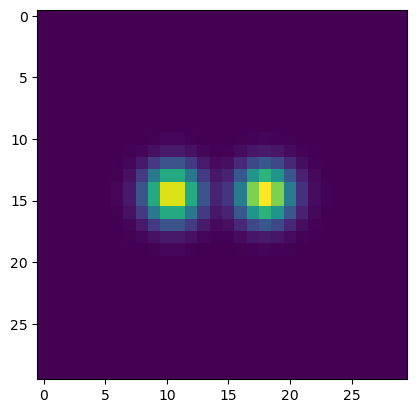

In [20]:
image = convolve.drawImage(nx=30, ny=30, scale=0.2, offset=(3.5, 0))
image = convolve.drawImage(image, scale=0.2, offset=(-4, 0), add_to_image=True)
plt.imshow(image.array)

Test the two image system

In [2]:
x_l, y_l = (0.1, 0.2)
x_ps, y_ps = (0.5, 0.7)
theta_E = 0.4

beta = np.sqrt((x_l-x_ps)**2+(y_l-y_ps)**2)
theta_p = (beta + np.sqrt(beta*beta+4*theta_E*theta_E))/2
theta_n = (beta - np.sqrt(beta*beta+4*theta_E*theta_E))/2
x = (theta_p/theta_E)**4
A_p = x/(x-1)
x = (theta_n/theta_E)**4
A_n = -x/(x-1)
assert A_p >= 0 and A_n >= 0

x_p = theta_p/beta*(x_ps - x_l) + x_l
y_p = theta_p/beta*(y_ps - y_l) + y_l
x_n = theta_n/beta*(x_ps - x_l) + x_l
y_n = theta_n/beta*(y_ps - y_l) + y_l

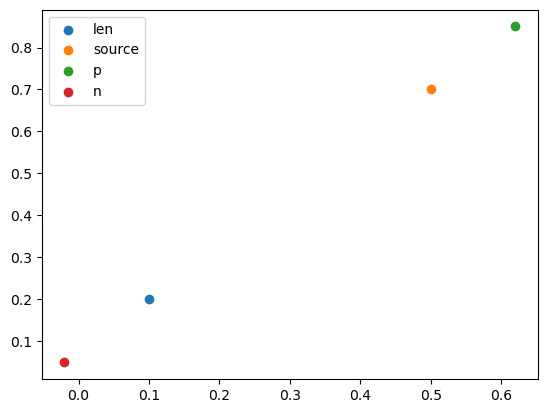

In [3]:
plt.scatter((x_l,), (y_l,), label='len')
plt.scatter((x_ps,), (y_ps,), label='source')
plt.scatter((x_p,), (y_p,), label='p')
plt.scatter((x_n,), (y_n, ), label='n')
plt.legend()
plt.show()

In [52]:
class SimpleImageModel:
    def __init__(self, pixel_size, nx, ny, origin, psf):
        self.pix_size = pixel_size
        self.origin = origin
        self.nx = nx
        self.ny = ny
        self.psf = psf
    def mock_image(self, theta_E, x_l, y_l, x_ps, y_ps, amp):
        beta = np.sqrt((x_l-x_ps)**2+(y_l-y_ps)**2)
        theta_p = (beta + np.sqrt(beta*beta+4*theta_E*theta_E))/2
        theta_n = (beta - np.sqrt(beta*beta+4*theta_E*theta_E))/2
        x = (theta_p/theta_E)**4
        A_p = x/(x-1)
        x = (theta_n/theta_E)**4
        A_n = -x/(x-1)
        assert A_p >= 0 and A_n >= 0

        self.x_l = x_l
        self.y_l = y_l
        self.x_ps = x_ps
        self.y_ps = y_ps
        self.x_p = theta_p/beta*(x_ps - x_l) + x_l
        self.y_p = theta_p/beta*(y_ps - y_l) + y_l
        self.x_n = theta_n/beta*(x_ps - x_l) + x_l
        self.y_n = theta_n/beta*(y_ps - y_l) + y_l
        self.A_p = A_p
        self.A_n = A_n
        
        p = galsim.DeltaFunction(flux=A_p)
        n = galsim.DeltaFunction(flux=A_n)

        con_p = galsim.Convolve([self.psf, p])
        con_n = galsim.Convolve([self.psf, n])

        image = con_p.drawImage(nx=self.nx, ny=self.ny, scale=self.pix_size, offset=(self.x_p/self.pix_size, self.y_p/self.pix_size))
        image = con_n.drawImage(image, scale=self.pix_size, add_to_image=True, offset=(self.x_n/self.pix_size, self.y_n/self.pix_size))
        return image

In [53]:
from lenstronomy.Cosmo.micro_lensing import einstein_radius
M0 = 1000
dl = 4000
ds = 8000
theta_E = einstein_radius(M0, dl, ds)

In [54]:
deltaPix = 0.01
fwhm=0.05
figsize = (fwhm+theta_E)*5
num_pix = int(figsize/deltaPix)
psf = galsim.Gaussian(fwhm=fwhm, flux=1)

In [55]:
mymodel = SimpleImageModel(deltaPix, num_pix, num_pix, (0, 0), psf)

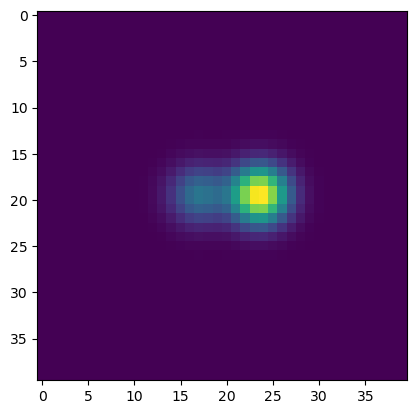

In [56]:
image = mymodel.mock_image(theta_E, 0, 0, theta_E*0.5, 0, 100)
plt.imshow(image.array)

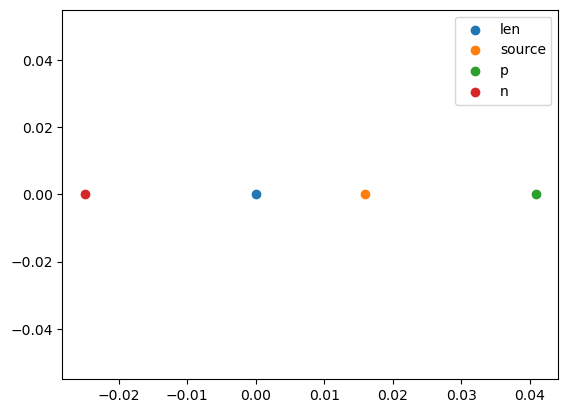

In [28]:
plt.scatter((mymodel.x_l,), (mymodel.y_l,), label='len')
plt.scatter((mymodel.x_ps,), (mymodel.y_ps,), label='source')
plt.scatter((mymodel.x_p,), (mymodel.y_p,), label='p')
plt.scatter((mymodel.x_n,), (mymodel.y_n, ), label='n')
plt.legend()
plt.show()

In [32]:
p = galsim.DeltaFunction(flux=mymodel.A_p)
n = galsim.DeltaFunction(flux=mymodel.A_n)
con_p = galsim.Convolve([psf, p])
con_n = galsim.Convolve([psf, n])

In [31]:
mymodel.A_p

1.591410312663499